In [1]:
import os

from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import roc_auc_score

def multi_roc_auc_score(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    columns = y_true.shape[1]
    column_losses = []
    for i in range(0, columns):
        column_losses.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
    return np.array(column_losses).mean()

def read_predictions(prediction_dir, mode='valid', valid_columns=None, stacking_mode='flat'):
    valid_labels = pd.read_csv(os.path.join(prediction_dir, 'valid_split.csv'))
    sample_submission = pd.read_csv(os.path.join(prediction_dir, 'sample_submission.csv'))
    predictions = []
    for filepath in sorted(glob.glob('{}/{}/*'.format(prediction_dir, mode))):
        prediction_single = pd.read_csv(filepath)
        prediction_single.drop('id', axis=1, inplace=True)
        predictions.append(prediction_single)

    if stacking_mode == 'flat':
        X = np.hstack(predictions)
    elif stacking_mode == 'rnn':
        X = np.stack(predictions, axis=2)
    else:
        raise NotImplementedError("""only stacking_mode options 'flat' and 'rnn' are supported""")

    if mode == 'valid':
        y = valid_labels[valid_columns].values
        return X, y
    elif mode == 'test':
        return X, sample_submission
    else:
        raise NotImplementedError

def get_model_names(prediction_dir):
    valid_predictions_dir = os.path.join(prediction_dir,'valid')
    filepaths = sorted(os.listdir(valid_predictions_dir))
    filepaths = [filepath.replace('_predictions_valid.csv','') for filepath in filepaths]
    return filepaths

In [3]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

SINGLE_DIR = '/public/toxic_comments/single_model_predictions_20180226'
ENSEMBLE_SUBMISSION_PATH = '/output/catboost_submission.csv'

# Validation Set Level 1 Predictions

In [4]:
X_valid, y_valid_multilabel = read_predictions(SINGLE_DIR, mode='valid',valid_columns=LABEL_COLUMNS, 
                                               stacking_mode='rnn')

cv_label = y_valid_multilabel[:,0]

# Test Set Level 1 Predictions

In [5]:
X_test, sample_submission = read_predictions(SINGLE_DIR, mode='test',stacking_mode='rnn')

In [6]:
model_names = get_model_names(SINGLE_DIR)

for i, model_name in enumerate(model_names):
    print(i, model_name)

0 bad_word_logreg
1 char_vdcnn
2 count_logreg
3 fasttext_dpcnn
4 fasttext_gru
5 fasttext_lstm
6 fasttext_scnn
7 glove_dpcnn
8 glove_gru
9 glove_lstm
10 glove_scnn
11 tfidf_logreg
12 word2vec_dpcnn
13 word2vec_gru
14 word2vec_lstm
15 word2vec_scnn


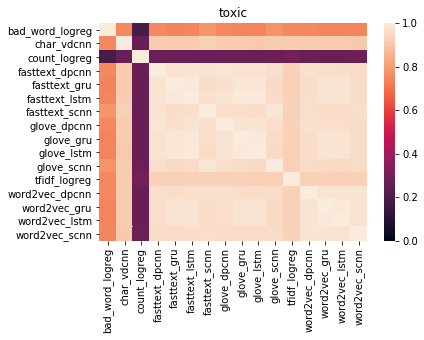

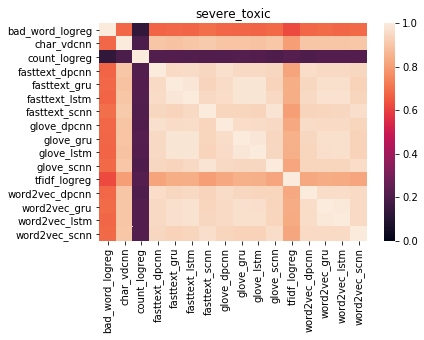

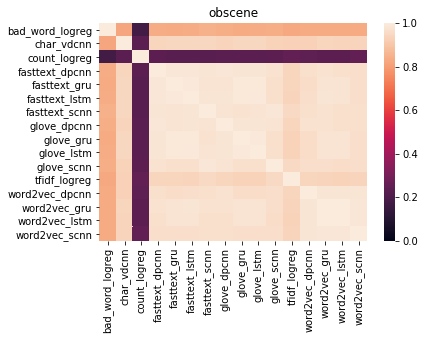

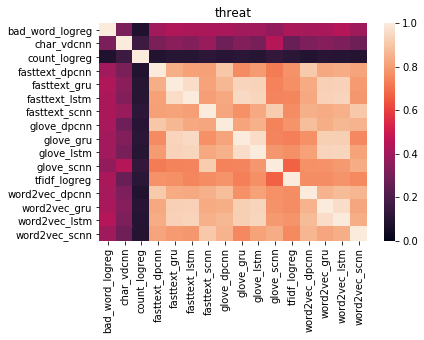

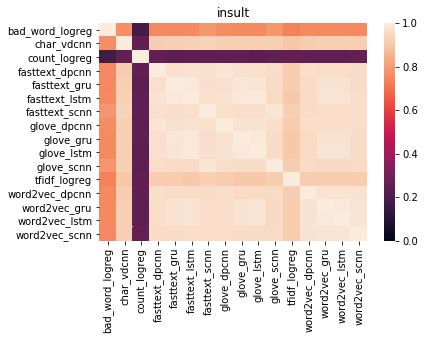

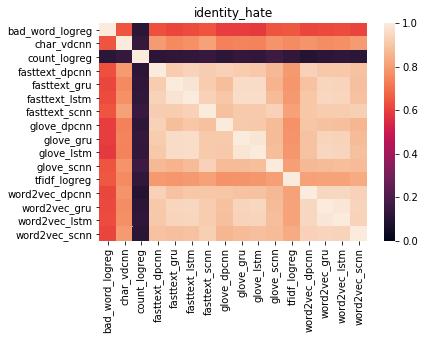

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for i, label in enumerate(LABEL_COLUMNS):
    label_predictions = pd.DataFrame(X_valid[:,i,:],columns = model_names)
    correlation_mat = label_predictions.corr()
    plt.title(label)
    sns.heatmap(correlation_mat, vmin=0.0, vmax=1.0)
    plt.show()

# Per-label Model

# Ensemble Training

In [8]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier


def fit_cv(estimator, params, X,y,label, n_splits=10):
    estimators,scores = [],[]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)
    skf.get_n_splits(label)
    for train_idx, valid_idx in skf.split(X, y):
        X_train_ = X[train_idx]
        y_train_ = y[train_idx]
        X_valid_ = X[valid_idx]
        y_valid_ =  y[valid_idx]
        
        estimator_ = estimator(**params) 
        estimator_.fit(X_train_, y_train_)
        y_valid_pred = estimator_.predict_proba(X_valid_)[:,1]
        score = roc_auc_score(y_valid_, y_valid_pred)
        estimators.append(estimator_)
        scores.append(score)
    return scores, estimators    

In [9]:
valid_scores = {}

# Toxic

In [10]:
estimator = XGBClassifier
    
params = dict(objective= 'rank:pairwise' ,#'binary:logistic'
  eval_metric= 'auc',
  n_estimators= 100,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.5,
  subsample= 0.6,
  colsample_bytree= 1.0, #0.3-0.5
  reg_lambda= 0.0, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

In [11]:
X_valid_label = X_valid[:,0,:]
y_valid_label = y_valid_multilabel[:,0]
scores, estimators = fit_cv(estimator,params, X_valid_label, y_valid_label, cv_label)   
valid_scores['toxic'] = scores
print('mean Toxic score {}'.format(np.mean(scores)))

mean Toxic score 0.9869481766112264


In [12]:
prediction_toxic = []
for estimator in estimators:
    pred = (estimator.predict_proba(X_test[:,0,:])[:,1])
    prediction_toxic.append(pred)
prediction_toxic = np.mean(np.stack(prediction_toxic,axis=-1),axis=-1)

# Severe Toxic

In [13]:
estimator = XGBClassifier
    
params = dict(objective= 'rank:pairwise' ,#'binary:logistic'
  eval_metric= 'auc',
  n_estimators= 100,
  learning_rate= 0.1,
  max_depth= 2,
  min_child_weight= 1,
  gamma=0.0,
  subsample= 0.9,
  colsample_bytree= 1.0, 
  reg_lambda= 0.0, 
  reg_alpha= 0.0,
  n_jobs=12)

In [14]:
X_valid_label = X_valid[:,1,:]
y_valid_label = y_valid_multilabel[:,1]
scores, estimators_toxic = fit_cv(estimator,params, X_valid_label, y_valid_label, cv_label)   
valid_scores['severe_toxic'] = scores
print('mean score {}'.format(np.mean(scores)))

mean score 0.9902865118142439


In [15]:
prediction_severe_toxic = []
for estimator in estimators:
    pred = (estimator.predict_proba(X_test[:,1,:])[:,1])
    prediction_severe_toxic.append(pred)
prediction_severe_toxic = np.mean(np.stack(prediction_severe_toxic,axis=-1),axis=-1)

# Obscene

In [16]:
estimator = XGBClassifier
    
params = dict(objective= 'rank:pairwise' ,#'binary:logistic'
  eval_metric= 'auc',
  n_estimators= 100,
  learning_rate= 0.1,
  max_depth= 2,
  min_child_weight= 5,
  gamma=0.0,
  subsample= 1.0,
  colsample_bytree= 0.6, 
  reg_lambda= 0.0, 
  reg_alpha= 0.0,
  n_jobs=12)

In [17]:
X_valid_label = X_valid[:,2,:]
y_valid_label = y_valid_multilabel[:,2]
scores, estimators_toxic = fit_cv(estimator,params, X_valid_label, y_valid_label, cv_label)  
valid_scores['obscene'] = scores
print('mean score {}'.format(np.mean(scores)))

mean score 0.9946500854585836


In [18]:
prediction_obscene = []
for estimator in estimators:
    pred = (estimator.predict_proba(X_test[:,2,:])[:,1])
    prediction_obscene.append(pred)
prediction_obscene = np.mean(np.stack(prediction_obscene,axis=-1),axis=-1) 

# Threat

In [19]:
estimator = XGBClassifier
    
params = dict(objective= 'rank:pairwise' ,#'binary:logistic'
  eval_metric= 'auc',
  n_estimators= 100,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 1.0,
  colsample_bytree= 1.0, 
  reg_lambda= 0.0, #0.01
  reg_alpha= 0.0,
  n_jobs=12)

In [20]:
X_valid_label = X_valid[:,3,:]
y_valid_label = y_valid_multilabel[:,3]
scores, estimators_toxic = fit_cv(estimator,params, X_valid_label, y_valid_label, cv_label)   
valid_scores['threat'] = scores
print('mean score {}'.format(np.mean(scores)))

mean score 0.9916983803366298


In [21]:
prediction_threat = []
for estimator in estimators:
    pred = (estimator.predict_proba(X_test[:,3,:])[:,1])
    prediction_threat.append(pred)
prediction_threat = np.mean(np.stack(prediction_threat,axis=-1),axis=-1) 

# Insult

In [22]:
estimator = XGBClassifier
    
params = dict(objective= 'rank:pairwise' ,#'binary:logistic'
  eval_metric= 'auc',
  n_estimators= 100,
  learning_rate= 0.1,
  max_depth= 2,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.3,
  colsample_bytree= 0.3, 
  reg_lambda= 0.0, #0.01
  reg_alpha= 0.0,
  n_jobs=12)

In [23]:
X_valid_label = X_valid[:,4,:]
y_valid_label = y_valid_multilabel[:,4]
scores, estimators_toxic = fit_cv(estimator,params, X_valid_label, y_valid_label, cv_label)  
valid_scores['insult'] = scores
print('mean score {}'.format(np.mean(scores)))

mean score 0.990941743021357


In [24]:
prediction_insult = []
for estimator in estimators:
    pred = (estimator.predict_proba(X_test[:,4,:])[:,1])
    prediction_insult.append(pred)
prediction_insult = np.mean(np.stack(prediction_insult,axis=-1),axis=-1) 

# Identity Hate

In [25]:
estimator = XGBClassifier
    
params = dict(objective= 'rank:pairwise' ,#'binary:logistic'
  eval_metric= 'auc',
  n_estimators= 100,
  learning_rate= 0.1,
  max_depth= 2,
  min_child_weight= 10,
  gamma=0.05,
  subsample= 1.0,
  colsample_bytree= 1.0, 
  reg_lambda= 0.0, #0.01
  reg_alpha= 0.0,
  n_jobs=12)

In [26]:
X_valid_label = X_valid[:,5,:]
y_valid_label = y_valid_multilabel[:,5]
scores, estimators_toxic = fit_cv(estimator,params, X_valid_label, y_valid_label, cv_label)   
valid_scores['identity_hate'] = scores
print('mean score {}'.format(np.mean(scores)))

mean score 0.9912492783967355


In [27]:
prediction_identity_hate = []
for estimator in estimators:
    pred = (estimator.predict_proba(X_test[:,5,:])[:,1])
    prediction_identity_hate.append(pred)
prediction_identity_hate = np.mean(np.stack(prediction_identity_hate,axis=-1),axis=-1) 

# Combine

In [28]:
final_cv_score = []
for label, scores in valid_scores.items():
    final_cv_score.append(np.mean(scores))
    print(label, np.mean(scores),np.std(scores))
print(np.mean(final_cv_score))

toxic 0.9869481766112264 0.004643328800036807
identity_hate 0.9912492783967355 0.00812387462835263
insult 0.990941743021357 0.0015192279020814835
obscene 0.9946500854585836 0.0011045626365982278
threat 0.9916983803366298 0.006156648037180046
severe_toxic 0.9902865118142439 0.0027320984727132913
0.9909623626064626


In [29]:
combined_predictions = np.stack([prediction_toxic, 
                                  prediction_severe_toxic,
                                  prediction_obscene,
                                  prediction_threat,
                                  prediction_insult, 
                                  prediction_identity_hate],axis=-1)
combined_predictions = np.round(combined_predictions,4)

In [30]:
submission = sample_submission
submission[LABEL_COLUMNS] = combined_predictions # this gets 0.9857 on LB
submission.to_csv(ENSEMBLE_SUBMISSION_PATH, index=None)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,5.6380,1.9626,5.4986,0.6132,4.8308,2.1474
1,0000247867823ef7,-4.6449,-4.3856,-4.6687,-4.3889,-4.7102,-4.3889
2,00013b17ad220c46,-3.9754,-4.3458,-4.5569,-4.3856,-4.6296,-4.3635
3,00017563c3f7919a,-4.7711,-4.3856,-4.3856,-4.3856,-4.3856,-4.3856
4,00017695ad8997eb,-3.6604,-4.3856,-4.8111,-4.3856,-4.7581,-4.3856
